In [1]:
# pip install torch torchvision pillow numpy opencv-python

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Dataset Extraction

# dataset_zip = "skin-burn-dataset.zip"
# extract_path = "dataset"

# if not os.path.exists(extract_path):
#     with zipfile.ZipFile(dataset_zip, "r") as zip_ref:
#         zip_ref.extractall(extract_path)
#     print("Dataset extracted successfully.")

In [4]:
# Device configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/user/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
# Pre-processing

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Loading Dataset ( Binary Classification )

train_data = datasets.ImageFolder(root="dataset/train", transform=transform_train)
val_data = datasets.ImageFolder(root="dataset/validate", transform=transform_test)
test_data = datasets.ImageFolder(root="dataset/test", transform=transform_test)

train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
val_loader   = DataLoader(val_data, batch_size = 16, shuffle = False)
test_loader = DataLoader(test_data, batch_size = 16, shuffle = False, drop_last = False)

In [15]:
# Loading Pre-trained Model- MobileNetV2

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)  # Burn vs No Burn
model = model.to(device)

In [17]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [19]:
# Training Loop
num_epochs = 10
train_loss, val_loss = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        image, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    avg_val_loss = running_loss / len(val_loader)
    val_loss.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Save Model
torch.save(model.state_dict(), "burn_detection.pth")
print("Model saved as burn_detection.pth")

Epoch [1/10], Train Loss: 0.6407, Val Loss: 1.5603
Epoch [2/10], Train Loss: 0.4153, Val Loss: 2.1446
Epoch [3/10], Train Loss: 0.3273, Val Loss: 0.3793
Epoch [4/10], Train Loss: 0.1668, Val Loss: 0.4489
Epoch [5/10], Train Loss: 0.1672, Val Loss: 0.9256
Epoch [6/10], Train Loss: 0.0854, Val Loss: 0.4387
Epoch [7/10], Train Loss: 0.0371, Val Loss: 0.7286
Epoch [8/10], Train Loss: 0.0318, Val Loss: 0.8767
Epoch [9/10], Train Loss: 0.0637, Val Loss: 0.6423
Epoch [10/10], Train Loss: 0.0837, Val Loss: 1.3247
Model saved as burn_detection.pth


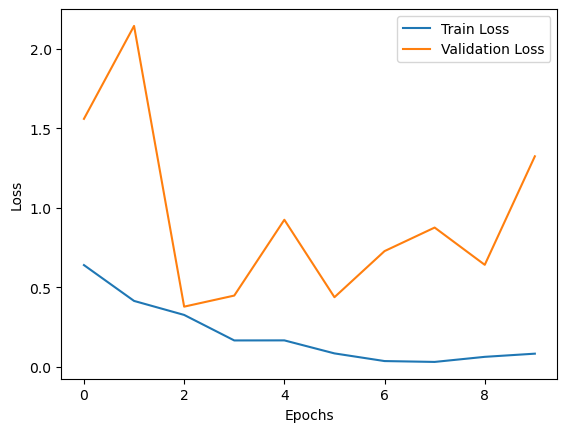

In [20]:
plt.plot(train_loss, label = "Train Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())  
        y_pred.extend(predicted.cpu().numpy())  
print(classification_report(y_true, y_pred, target_names=test_data.classes, zero_division=1))


              precision    recall  f1-score   support

        burn       0.79      0.92      0.85        25
     no_burn       0.90      0.75      0.82        24

    accuracy                           0.84        49
   macro avg       0.85      0.83      0.84        49
weighted avg       0.85      0.84      0.84        49



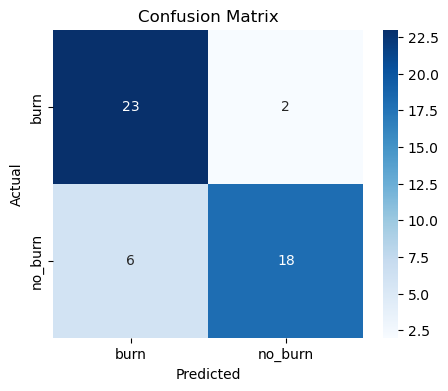

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()